In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
import dalex as dx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
df = pd.read_csv("winequality-red.csv")

In [8]:
ProfileReport(df)
ProfileReport(df).to_file(output_file='wine_classification_profiling_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Comment on EDA:

Distributions:
sulphates, pH and fixed acidity seem to have normal distribution. This will be later checked with a statistical test.

Correlations (Spearmans):
Fixed acidity - negative correlation between pH. Explainable with basic chemistry knowledge - there are 14 values on pH scale. The lower the value, the higher the acidity. Substances regarded as "acidic" would be in range (1, 7) . Substances regarded as "alkaline", would be in range (7, 14). In this case, higher acidity -> more acidic substance -> lower pH.

Fixed acidity - positive correlation between citric acid. Citric acid is regarded as acidic substance, so a natural correlation occurs.
Fixed acidity - positive correlation between density. Acidic substances are more dense than water (which has pH equal to 7).

Volatile acidity - negative correlation between quality. As described in the dataset, it is "the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste"

In [9]:
df.drop_duplicates(inplace=True)

Normality tests for variables:

In [12]:
for i in df.columns:
    print(f'''{i} does {'not' if stats.shapiro(df[i]).pvalue < 0.05 else ''} have a normal distribution on 5% confidence level, based on Shapiro-Wilk test, test stat: {round(stats.shapiro(df[i]).statistic, 2)}, p-val: {round(stats.shapiro(df[i]).pvalue, 4)}''')

fixed acidity does not have a normal distribution on 5% confidence level, based on Shapiro-Wilk test, test stat: 0.95, p-val: 0.0
volatile acidity does not have a normal distribution on 5% confidence level, based on Shapiro-Wilk test, test stat: 0.97, p-val: 0.0
citric acid does not have a normal distribution on 5% confidence level, based on Shapiro-Wilk test, test stat: 0.96, p-val: 0.0
residual sugar does not have a normal distribution on 5% confidence level, based on Shapiro-Wilk test, test stat: 0.58, p-val: 0.0
chlorides does not have a normal distribution on 5% confidence level, based on Shapiro-Wilk test, test stat: 0.48, p-val: 0.0
free sulfur dioxide does not have a normal distribution on 5% confidence level, based on Shapiro-Wilk test, test stat: 0.9, p-val: 0.0
total sulfur dioxide does not have a normal distribution on 5% confidence level, based on Shapiro-Wilk test, test stat: 0.87, p-val: 0.0
density does not have a normal distribution on 5% confidence level, based on Sha

# Approach

1) Quality prediction

2) Prediction weather the wine is good or bad

In [13]:
y = df["quality"]
X = df.drop(["quality", "pH", "citric acid", "density"], axis = 1) #dropping highly correlated features
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=42)

Quality prediction - regression metric used will be MSE
linear regression - OLS

In [14]:
x_lr = X
x_lr = sm.add_constant(x_lr)
model = sm.OLS(y, x_lr)
results = model.fit()

In [15]:
print(f'''p-value for white's heteroskedascity test is: {sm.stats.diagnostic.het_white(results.resid,  results.model.exog)[1]}''')


p-value for white's heteroskedascity test is: 7.687441900163101e-20


In [16]:
results_r = model.fit(cov_type="HC1")
results_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     91.75
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          1.18e-121
Time:                        20:30:24   Log-Likelihood:                -1361.4
No. Observations:                1359   AIC:                             2741.
Df Residuals:                    1350   BIC:                             2788.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.6863      0.304      8.843      0.000       2.091       3.282
fixed acidity            0.0224      0.013      1.675      0.094      -0.004       0.049
volatile acidity        -1.1138      0.124     -8.972      0.000      -1.357      -0.871
residual sugar           0.0021      0.017      0.123      0.902      -0.031       0.035
chlorides               -1.7725      0.462     -3.840      0.000      -2.677      -0.868
free sulfur dioxide      0.0030      0.002      1.262      0.207      -0.002       0.008
total sulfur dioxide    -0.0025      0.001     -3.248      0.001      -0.004      -0.001
sulphates                0.8949      0.144      6.199      0.000       0.612       1.178
alcohol                  0.2848      0.021     13.317      0.000       0.243       0.327
==============================================================================
Omnibus:                       28.656   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.599
Skew:                          -0.208   Prob(JB):                     5.62e-10
Kurtosis:                       3.761   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [20]:
vif_adj_cols = vif_data[vif_data.VIF < 10]["feature"].values

Creating more general model

In [21]:
vif_adj_x = X[vif_adj_cols]
vif_adj_x = sm.add_constant(vif_adj_x)

In [22]:
model_vif_adj = sm.OLS(y, vif_adj_x)
results_v = model_vif_adj.fit(cov_type="HC1")
results_v.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     61.14
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           1.50e-57
Time:                        20:35:05   Log-Likelihood:                -1517.5
No. Observations:                1359   AIC:                             3047.
Df Residuals:                    1353   BIC:                             3078.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.7409      0.082     81.936      0.000       6.580       6.902
volatile acidity        -1.6809      0.122    -13.790      0.000      -1.920      -1.442
residual sugar           0.0273      0.019      1.475      0.140      -0.009       0.064
chlorides               -1.7082      0.374     -4.569      0.000      -2.441      -0.975
free sulfur dioxide      0.0054      0.003      2.014      0.044       0.000       0.011
total sulfur dioxide    -0.0050      0.001     -5.387      0.000      -0.007      -0.003
==============================================================================
Omnibus:                       17.069   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.565
Skew:                           0.139   Prob(JB):                     7.64e-06
Kurtosis:                       3.582   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
regression_results = {"OLS": mean_squared_error(y, results_v.predict())}

Xgboost

In [25]:
xgb_model = xgb.XGBRegressor()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
xgb_model.fit(X_train, y_train)
scores = cross_val_score(xgb_model, X_test, y_test, scoring="neg_mean_squared_error", cv=cv)
regression_results["XGB"] = abs(scores.mean())

In [26]:
%matplotlib inline

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

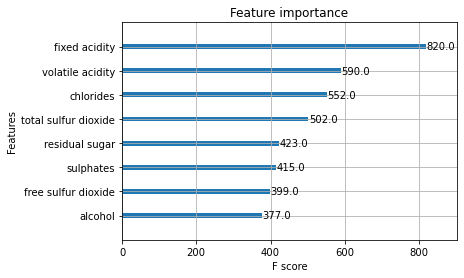

In [27]:
xgb.plot_importance(xgb_model)
